In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getEPPA(ell, ndays, case):
    fldStr = {'orig': '_orig_2016',
               'crseAtm':'_crseAtm_2016',
               'Recipe':'_Recipe_2016'
                }
    
    fileStr = {'orig': 'weeklyAvg',
               'crseAtm':'crseAtm_weeklyAvg_2p5deg',
               'Recipe':'Recipe_weeklyAvg_2p5deg'
                }
    
    fldLoc = '/pscratch/sd/s/srai/ROMSwithWRF/run/output{0:s}/{1:d}km/'.format(fldStr[case], ell)
    EPPA = np.zeros((ndays, 434, 1120), dtype=float)
    for day in range(ndays):
        fileName = 'ROMS_withWRF_data_{2:s}_filteredAt_{0:04d}_timeAt{1:03d}.nc'.format(ell, day, fileStr[case])
        ds = Dataset(fldLoc + fileName)
        ut = np.array(ds.variables['tauxUo'])
        vt = np.array(ds.variables['tauyVo'])
        uo = np.array(ds.variables['uo'])
        vo = np.array(ds.variables['vo'])
        tx = np.array(ds.variables['taux'])
        ty = np.array(ds.variables['tauy'])
        EPPA[day,:,:] = (ut - tx*uo) +(vt - ty*vo)
    return EPPA

In [3]:
gridDS = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/input/ROMSgrid.nc')
UAREA = np.array(gridDS.variables['UAREA'])
gridDS.variables.keys()

# kmtDS = Dataset('/gpfs/fs1/home/srai6/Desktop/SecondEddyKillingPaper/ROMSandWRF/Instantaneous/KMT_ROMSnWRF.nc')
# kmt = np.array(kmtDS.variables['KMT'][:,:], dtype=float)

dict_keys(['ULAT', 'ULONG', 'DXU', 'DYU', 'RADIUS', 'UAREA'])

In [4]:
mask = np.zeros(UAREA.shape, dtype=float)
mask[70:-70,70:-70] = 1

In [5]:
ellList = [10, 20, 50, 80, 100, 200, 300, 500, 800]
ndays = 21
nell = len(ellList)

EPPA = np.zeros((nell, ndays, 434, 1120), dtype=float)
EPPA_crseAtm = np.zeros((nell, ndays, 434, 1120), dtype=float)
EPPA_Recipe = np.zeros((nell, ndays, 434, 1120), dtype=float)

In [6]:
for i in range(nell):
    EPPA[i,:,:,:] = getEPPA(ellList[i], ndays, 'orig')
    EPPA_crseAtm[i,:,:,:] = getEPPA(ellList[i], ndays, 'crseAtm')
    EPPA_Recipe[i,:,:,:] = getEPPA(ellList[i], ndays, 'Recipe')

In [7]:
def getAreaAvgEPPA(EPPA, UAREA, mask):
    totArea = np.nansum(UAREA * mask)
    areaAvgEPPA = np.nansum((UAREA * EPPA * mask), axis=(2,3))/totArea
    return areaAvgEPPA

areaAvg_EPPA = getAreaAvgEPPA(EPPA , UAREA, mask)
areaAvg_EPPA_crseAtm = getAreaAvgEPPA(EPPA_crseAtm , UAREA, mask)
areaAvg_EPPA_Recipe = getAreaAvgEPPA(EPPA_Recipe , UAREA, mask)

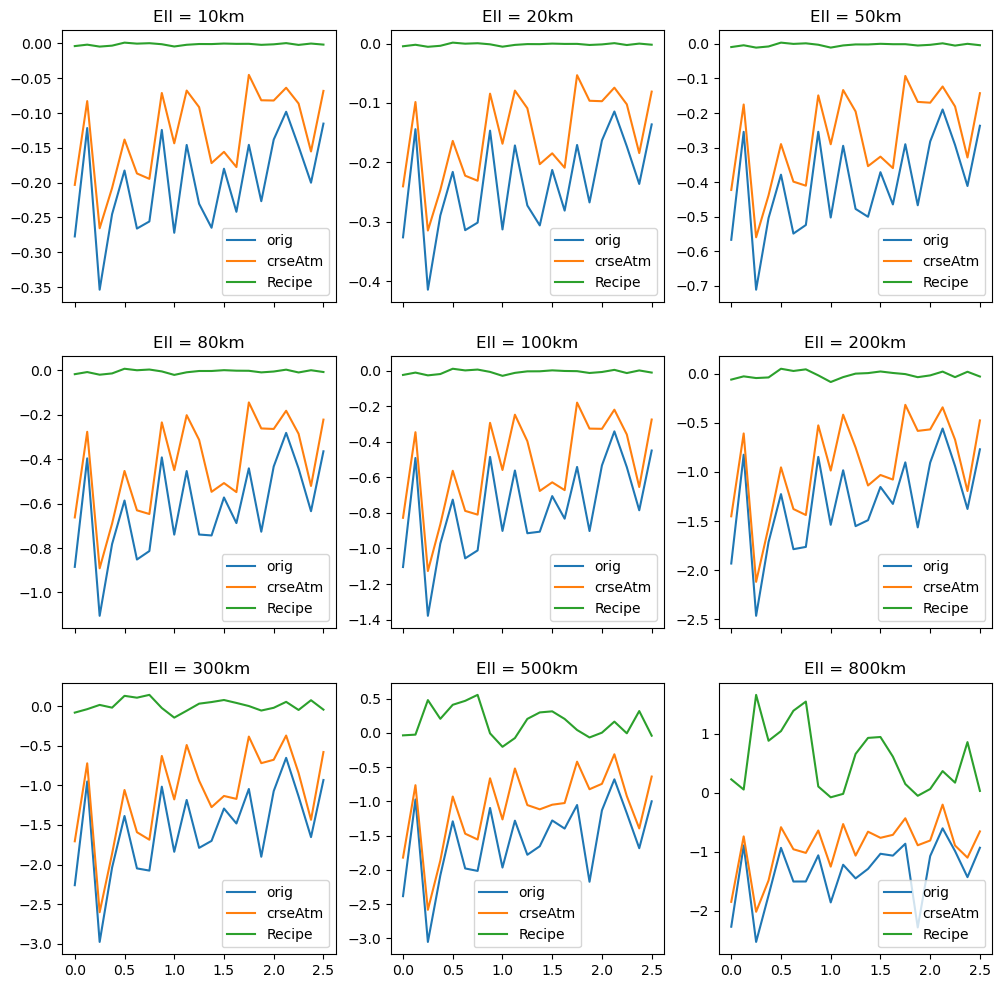

In [8]:
#ndays = 100
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True)
for i in range(nell):
    ii = int(i//3)
    jj = int(i%3)
    ellIdx = i
    axes[ii, jj].plot(np.arange(ndays)/8, areaAvg_EPPA[ellIdx, 0:ndays]*1e3, label = 'orig')
    axes[ii, jj].plot(np.arange(ndays)/8, areaAvg_EPPA_crseAtm[ellIdx, 0:ndays]*1e3, label = 'crseAtm')
    axes[ii, jj].plot(np.arange(ndays)/8, areaAvg_EPPA_Recipe[ellIdx, 0:ndays]*1e3, label = 'Recipe')
    axes[ii, jj].legend()
    axes[ii,jj].set_title('Ell = '+str(ellList[i])+'km')

In [9]:
timeAreaAvg_EPPA = np.mean(areaAvg_EPPA, axis=1)
timeAreaAvg_EPPA_crseAtm = np.mean(areaAvg_EPPA_crseAtm, axis=1)
timeAreaAvg_EPPA_Recipe = np.mean(areaAvg_EPPA_Recipe, axis=1)

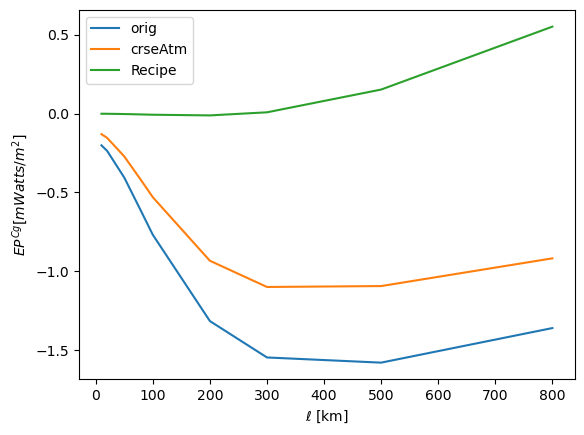

In [10]:
plt.plot(ellList, 1e3*timeAreaAvg_EPPA, label = 'orig')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_crseAtm, label = 'crseAtm')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_Recipe, label = 'Recipe')
plt.xlabel(r'$\ell$ [km]')
plt.ylabel(r'$EP^{Cg} [mWatts/m^2]$')
plt.legend()

(434, 1120)


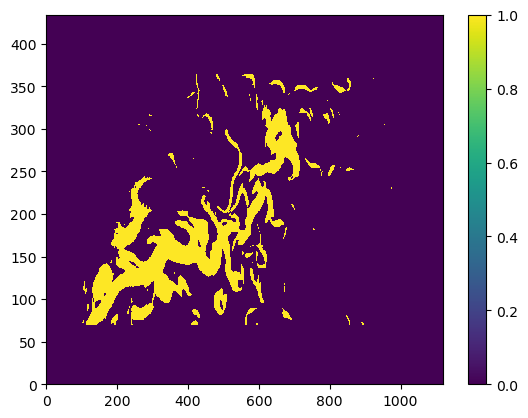

In [11]:
maskKE_ds = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/input/mask.nc')
maskKE = np.array(maskKE_ds.variables['highKEandEKEmask'][:,:])
maskKE[0:70,:] = 0
maskKE[:,0:70] = 0
maskKE[434-70:434,:] = 0
maskKE[:,1120-70:1120] = 0
print(maskKE.shape)
plt.pcolormesh(maskKE)
plt.colorbar()

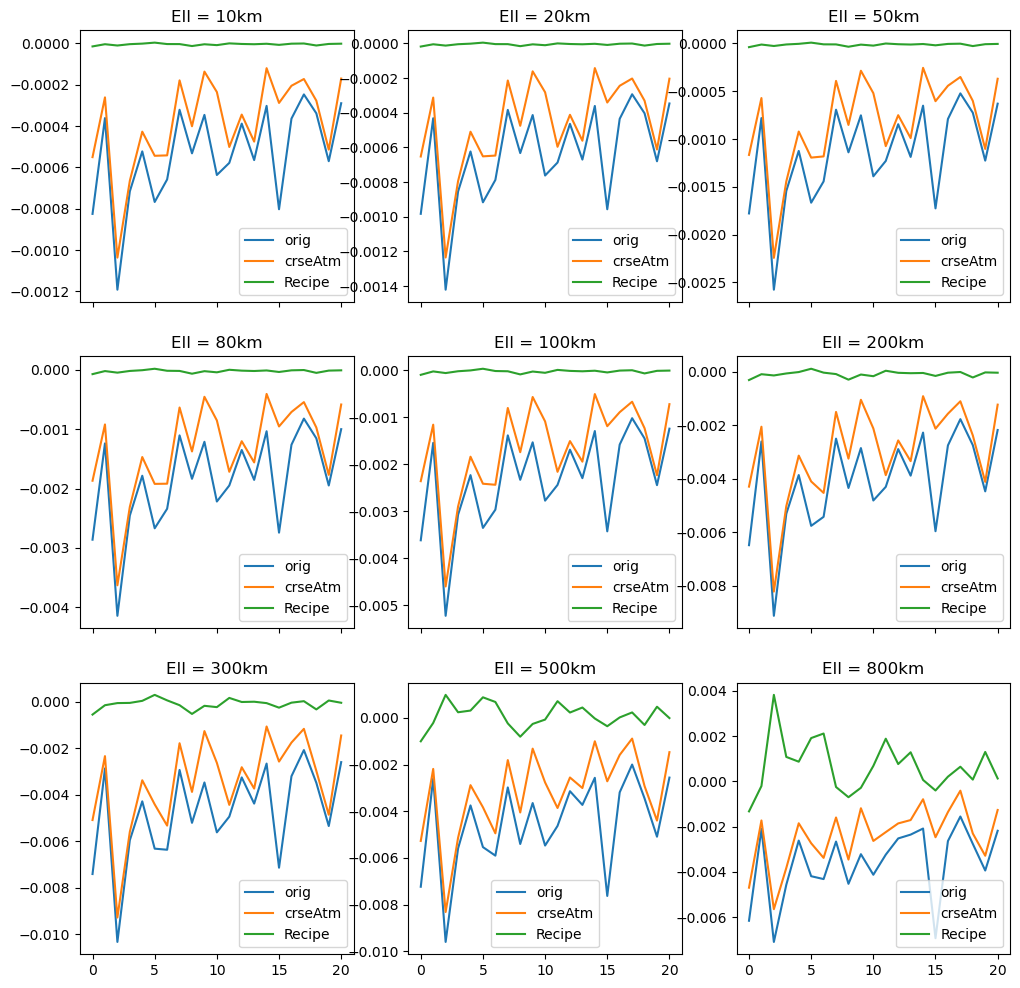

In [12]:
areaAvg_EPPA_highKE = getAreaAvgEPPA(EPPA , UAREA, maskKE)
areaAvg_EPPA_crseAtm_highKE = getAreaAvgEPPA(EPPA_crseAtm , UAREA, maskKE)
areaAvg_EPPA_Recipe_highKE = getAreaAvgEPPA(EPPA_Recipe , UAREA, maskKE)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True)
for i in range(nell):
    ii = int(i//3)
    jj = int(i%3)
    ellIdx = i
    axes[ii, jj].plot(areaAvg_EPPA_highKE[ellIdx, :], label = 'orig')
    axes[ii, jj].plot(areaAvg_EPPA_crseAtm_highKE[ellIdx, :], label = 'crseAtm')
    axes[ii, jj].plot(areaAvg_EPPA_Recipe_highKE[ellIdx, :], label = 'Recipe')
    axes[ii, jj].legend()
    axes[ii,jj].set_title('Ell = '+str(ellList[i])+'km')

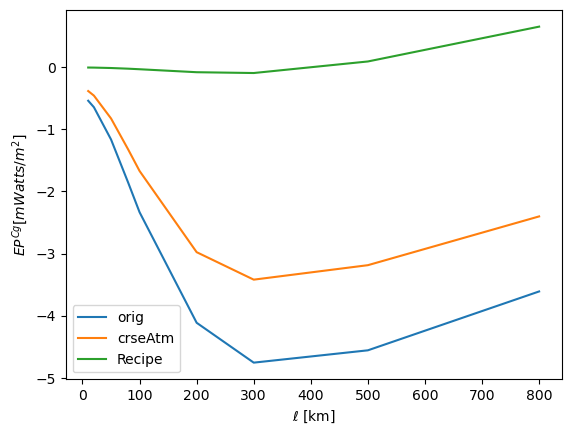

In [13]:
timeAreaAvg_EPPA_highKE = np.mean(areaAvg_EPPA_highKE, axis=1)
timeAreaAvg_EPPA_crseAtm_highKE = np.mean(areaAvg_EPPA_crseAtm_highKE, axis=1)
timeAreaAvg_EPPA_Recipe_highKE = np.mean(areaAvg_EPPA_Recipe_highKE, axis=1)

plt.plot(ellList, 1e3*timeAreaAvg_EPPA_highKE, label = 'orig')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_crseAtm_highKE, label = 'crseAtm')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_Recipe_highKE, label = 'Recipe')
plt.xlabel(r'$\ell$ [km]')
plt.ylabel(r'$EP^{Cg} [mWatts/m^2]$')
plt.legend()

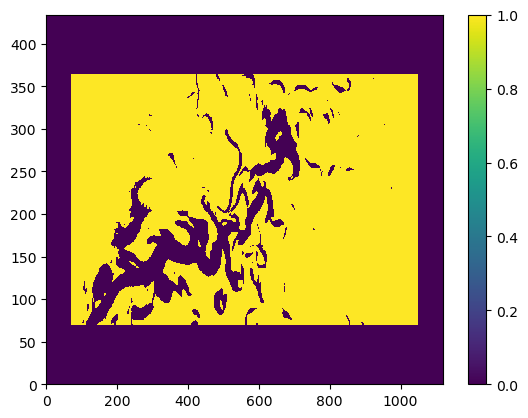

In [14]:
maskLowKE = 1 - maskKE
maskLowKE[0:70,:] = 0
maskLowKE[:,0:70] = 0
maskLowKE[434-70:434,:] = 0
maskLowKE[:,1120-70:1120] = 0

plt.pcolormesh(maskLowKE)
plt.colorbar()

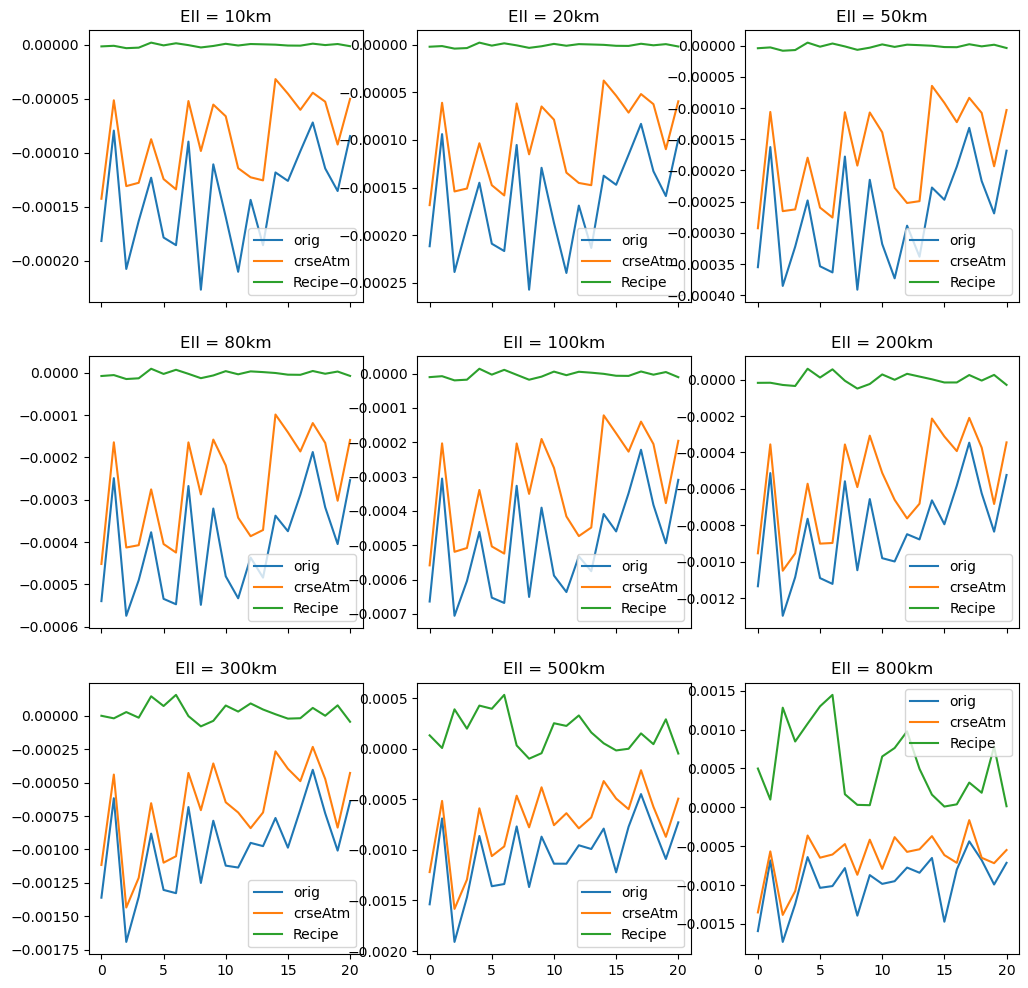

In [15]:
areaAvg_EPPA_lowKE = getAreaAvgEPPA(EPPA , UAREA, maskLowKE)
areaAvg_EPPA_crseAtm_lowKE = getAreaAvgEPPA(EPPA_crseAtm , UAREA, maskLowKE)
areaAvg_EPPA_Recipe_lowKE = getAreaAvgEPPA(EPPA_Recipe , UAREA, maskLowKE)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True)
for i in range(nell):
    ii = int(i//3)
    jj = int(i%3)
    ellIdx = i
    axes[ii, jj].plot(areaAvg_EPPA_lowKE[ellIdx, :], label = 'orig')
    axes[ii, jj].plot(areaAvg_EPPA_crseAtm_lowKE[ellIdx, :], label = 'crseAtm')
    axes[ii, jj].plot(areaAvg_EPPA_Recipe_lowKE[ellIdx, :], label = 'Recipe')
    axes[ii, jj].legend()
    axes[ii,jj].set_title('Ell = '+str(ellList[i])+'km')

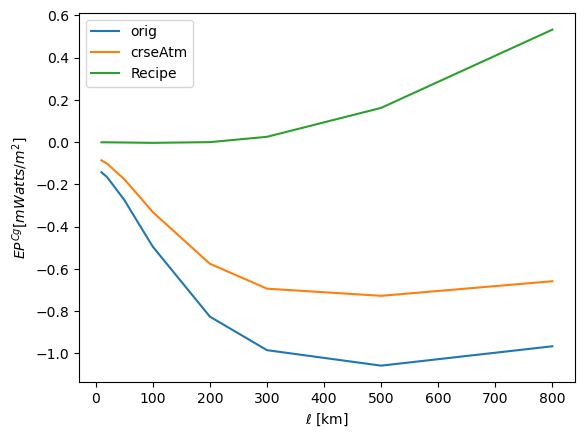

In [16]:
timeAreaAvg_EPPA_lowKE = np.mean(areaAvg_EPPA_lowKE, axis=1)
timeAreaAvg_EPPA_crseAtm_lowKE = np.mean(areaAvg_EPPA_crseAtm_lowKE, axis=1)
timeAreaAvg_EPPA_Recipe_lowKE = np.mean(areaAvg_EPPA_Recipe_lowKE, axis=1)

plt.plot(ellList, 1e3*timeAreaAvg_EPPA_lowKE, label = 'orig')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_crseAtm_lowKE, label = 'crseAtm')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_Recipe_lowKE, label = 'Recipe')
plt.xlabel(r'$\ell$ [km]')
plt.ylabel(r'$EP^{Cg} [mWatts/m^2]$')
plt.legend()